In [2]:
import os
import re
import glob
import pandas as pd
from datetime import datetime, timedelta

In [3]:
#Parsing non fengyun satellelites

In [4]:
# Helper functions for date conversion
def doy_to_datetime(year: int, doy: int, hour: int, minute: int, second: float=0.0):
    """
    Convert year, day-of-year, hour, minute, and second to a datetime object.
    """
    date = datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)
    return date

In [5]:
#a=doy_to_datetime(2025,1,1,1,4)
#print(a)

In [6]:
def parse_non_fengyun_line(line: str):
    """
    Parse a line from a non-Fengyun manoeuvre file.
    Expected format (sample):
      CRYO2 2010 105 17 47 2010 105 17 48 006 1 2010 105 17 47 34.000 ...
    This function extracts the satellite name and the start and end times.
    (You may need to adjust token indices based on the actual format.)
    """
    # Split the line by whitespace; multiple spaces are automatically handled.
    tokens = line.split()
    if len(tokens) < 9:
        return None

    # Example parsing:
    # tokens[0] : Satellite name
    # tokens[1:5] : start time (year, doy, hour, minute)
    # tokens[5:9] : end time (year, doy, hour, minute)
    try:
        sat_name = tokens[0]
        start_year = int(tokens[1])
        start_doy  = int(tokens[2])
        start_hour = int(tokens[3])
        start_min  = int(tokens[4])
        # You could also check for seconds if provided:
        # For this example, assume seconds=0 unless later tokens specify otherwise.
        end_year = int(tokens[5])
        end_doy  = int(tokens[6])
        end_hour = int(tokens[7])
        end_min  = int(tokens[8])
        # If seconds are available later, you can parse them here.
        start_dt = doy_to_datetime(start_year, start_doy, start_hour, start_min)
        end_dt = doy_to_datetime(end_year, end_doy, end_hour, end_min)
    except Exception as e:
        print(f"Error parsing line: {line}\n{e}")
        return None

    return {'satellite': sat_name, 'start_time': start_dt, 'end_time': end_dt}

In [7]:
#Parsing fengyun satellites

In [8]:
def parse_fengyun_line(line: str):
    """
    Parse a line from a Fengyun manoeuvre file.
    Expected format (sample):
      GEO-EW-STATION-KEEPING 2006-053A "2015-04-10T15:30:00 CST" "2015-04-10T16:30:00 CST"
    Uses regex to extract the satellite identifier and the quoted timestamps.
    """
    pattern = r'(\S+)\s+(\S+)\s+"([^"]+)"\s+"([^"]+)"'
    match = re.match(pattern, line)
    if not match:
        print(f"Line did not match Fengyun format: {line}")
        return None

    sat_code = match.group(1)
    # the second token (e.g., 2006-053A) may be an identifier; you can choose to combine it
    sat_id = f"{sat_code} {match.group(2)}"
    start_str = match.group(3)
    end_str   = match.group(4)

    # Remove timezone (e.g., CST) if necessary and parse using a format.
    # Here we assume the timestamps are in ISO format (except for the trailing timezone)
    def clean_timestamp(ts: str):
        # Remove any trailing timezone info if present
        return ts.split()[0] if " " in ts else ts

    start_str = clean_timestamp(start_str)
    end_str = clean_timestamp(end_str)
    try:
        start_dt = datetime.fromisoformat(start_str)
        end_dt = datetime.fromisoformat(end_str)
    except Exception as e:
        print(f"Error parsing Fengyun timestamps in line: {line}\n{e}")
        return None

    return {'satellite': sat_id, 'start_time': start_dt, 'end_time': end_dt}

In [9]:
# Functions to read and preprocess files

In [10]:
def process_manoeuvre_file(filepath: str):
    """
    Process a manoeuvre file and return a DataFrame with standardized columns.
    Handles both Fengyun and non-Fengyun files based on the file extension.
    """
    records = []
    filename = os.path.basename(filepath)
    is_fengyun = filename.lower().endswith(".fy")  # Fengyun files have .fy extension

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if is_fengyun:
                rec = parse_fengyun_line(line)
            else:
                rec = parse_non_fengyun_line(line)
            if rec is not None:
                records.append(rec)
    df = pd.DataFrame(records)
    return df


In [11]:
def process_orbital_elements_file(filepath: str):
    """
    Process an orbital elements CSV file.
    Assumes the CSV file has a header and one column contains the timestamp.
    Converts the timestamp column to datetime and renames columns to a standard naming.
    """
    df = pd.read_csv(filepath, sep=',')
    # Assume the first column is a timestamp string – you may need to adjust the column name.
        # Rename the first column to 'timestamp' if it's unnamed
    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except Exception as e:
        print(f"Error converting timestamp in {filepath}: {e}")
    # Rename columns for consistency
    rename_map = {
        'eccentricity': 'eccentricity',
        'argument of perigee': 'arg_perigee',
        'inclination': 'inclination',
        'mean anomaly': 'mean_anomaly',
        'Brouwer mean motion': 'mean_motion',
        'right ascension': 'right_ascension'
    }
    df.rename(columns=rename_map, inplace=True)
    # Optionally add a column with the satellite name based on the filename
    sat_name = os.path.splitext(os.path.basename(filepath))[0]
    df['satellite'] = sat_name
    return df


    # Rename the first column to 'timestamp' if it's unnamed
    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)

    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except Exception as e:
        print(f"Error converting timestamp in {filepath}: {e}")

    

In [12]:
"""a= process_orbital_elements_file("orbital_elements/CryoSat-2.csv")
print(a)"""

'a= process_orbital_elements_file("orbital_elements/CryoSat-2.csv")\nprint(a)'

In [13]:
# Main processing: iterate through directories and combine data

In [14]:
def main():
    # Set your input directories for manoeuvre files and orbital element files
    manoeuvres_dir = './manoeuvres'
    orbital_elements_dir = './orbital_elements'

# Process manoeuvre files
    manoeuvre_files = glob.glob(os.path.join(manoeuvres_dir, "*"))
    manoeuvre_dfs = []
    for filepath in manoeuvre_files:
        print(f"Processing manoeuvre file: {filepath}")
        df = process_manoeuvre_file(filepath)
        if not df.empty:
            manoeuvre_dfs.append(df)
    if manoeuvre_dfs:
        manoeuvres_all = pd.concat(manoeuvre_dfs, ignore_index=True)
        # Sort by satellite and start_time for clarity
        manoeuvres_all.sort_values(by=['satellite', 'start_time'], inplace=True)
        # Save standardized manoeuvre data
        manoeuvres_all.to_csv('standardized_manoeuvres.csv', index=False)
        print("Saved standardized manoeuvre data to standardized_manoeuvres.csv")
    else:
        print("No manoeuvre data processed.")

        
        
# Process orbital element files
    orbital_files = glob.glob(os.path.join(orbital_elements_dir, "*.csv"))
    orbital_dfs = []
    for filepath in orbital_files:
        print(f"Processing orbital element file: {filepath}")
        df = process_orbital_elements_file(filepath)
        orbital_dfs.append(df)
    if orbital_dfs:
        orbital_all = pd.concat(orbital_dfs, ignore_index=True)
        # Sort by satellite and timestamp
        orbital_all.sort_values(by=['satellite', orbital_all.columns[0]], inplace=True)
        orbital_all.to_csv('standardized_orbital_elements.csv', index=False)
        print("Saved standardized orbital element data to standardized_orbital_elements.csv")
    else:
        print("No orbital element data processed.")

if __name__ == '__main__':
    main()


Processing manoeuvre file: ./manoeuvres/manFY2D.txt.fy
Processing manoeuvre file: ./manoeuvres/manFY2H.txt.fy
Processing manoeuvre file: ./manoeuvres/srlman.txt
Processing manoeuvre file: ./manoeuvres/en1man.txt
Processing manoeuvre file: ./manoeuvres/manFY2F.txt.fy
Processing manoeuvre file: ./manoeuvres/topman.txt
Processing manoeuvre file: ./manoeuvres/sp4man.txt
Processing manoeuvre file: ./manoeuvres/s3aman.txt
Processing manoeuvre file: ./manoeuvres/manFY4A.txt.fy
Processing manoeuvre file: ./manoeuvres/ja1man.txt
Processing manoeuvre file: ./manoeuvres/sp2man.txt
Processing manoeuvre file: ./manoeuvres/ja3man.txt
Processing manoeuvre file: ./manoeuvres/h2dman.txt
Processing manoeuvre file: ./manoeuvres/h2aman.txt
Processing manoeuvre file: ./manoeuvres/manFY2E.txt.fy
Error parsing Fengyun timestamps in line: GEO-NS-STATION-KEEPING 2008-066A "2015-12-22T00:00:00 CST" "2015/12/23T23:59:59 CST"
Invalid isoformat string: '2015/12/23T23:59:59'
Processing manoeuvre file: ./manoeuvres/


===== ECCENTRICITY =====


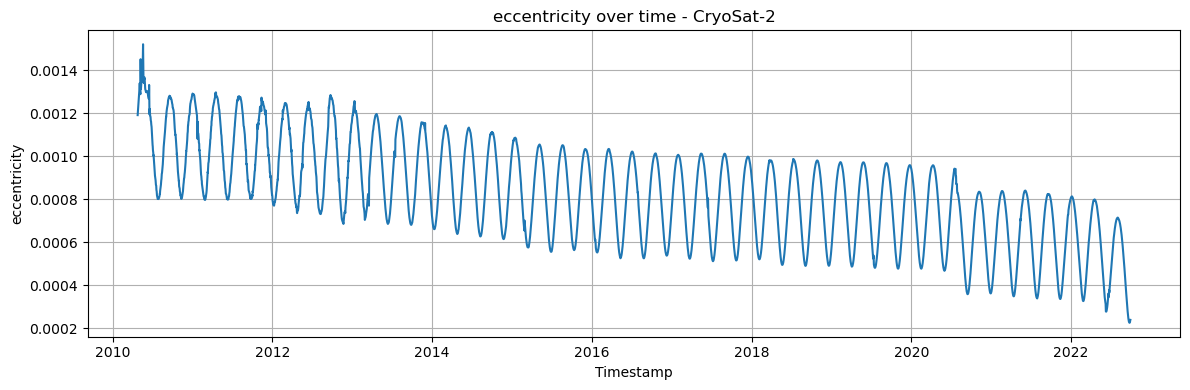

ADF Statistic: -4.1493, p-value: 0.0008
Likely Stationary


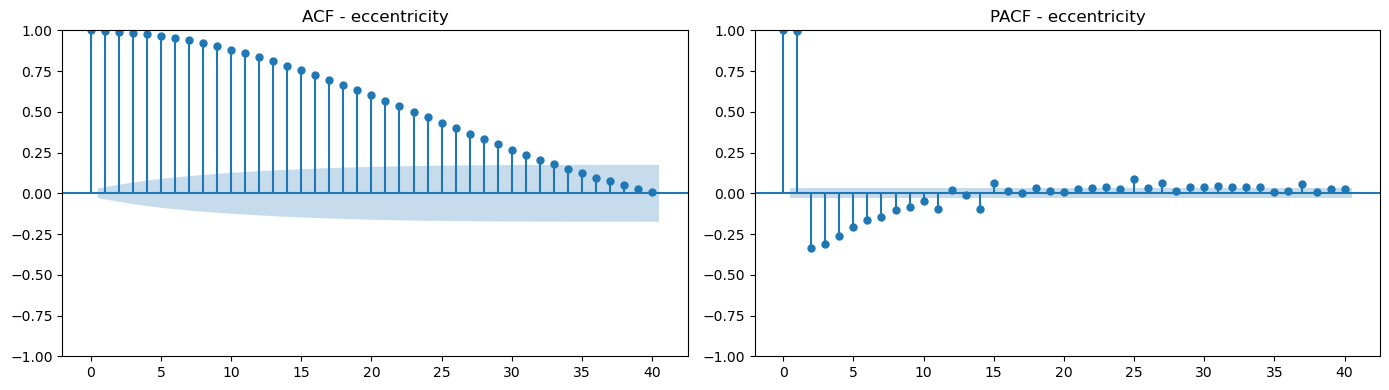


===== ARG_PERIGEE =====


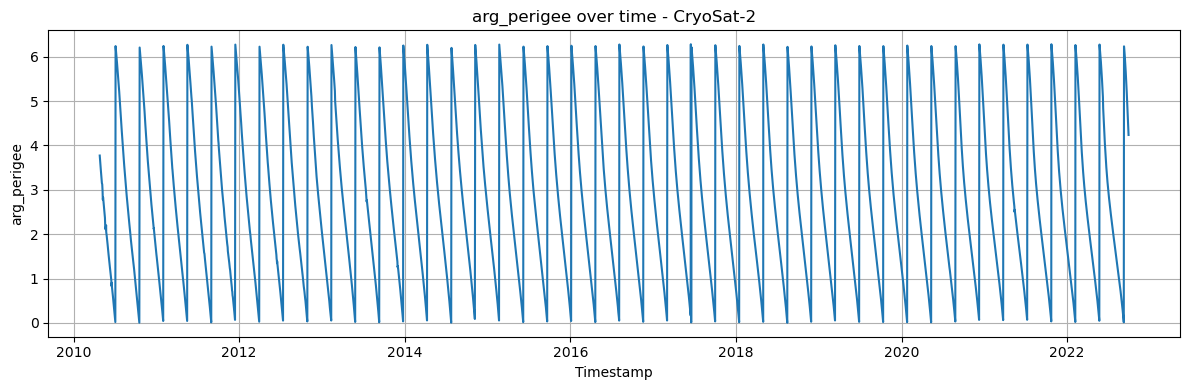

ADF Statistic: -13.4042, p-value: 0.0000
Likely Stationary


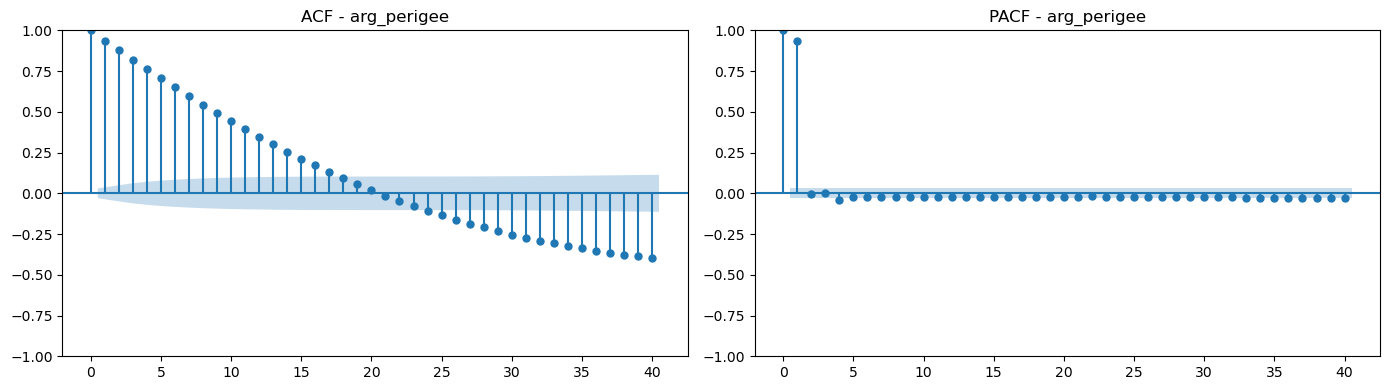


===== INCLINATION =====


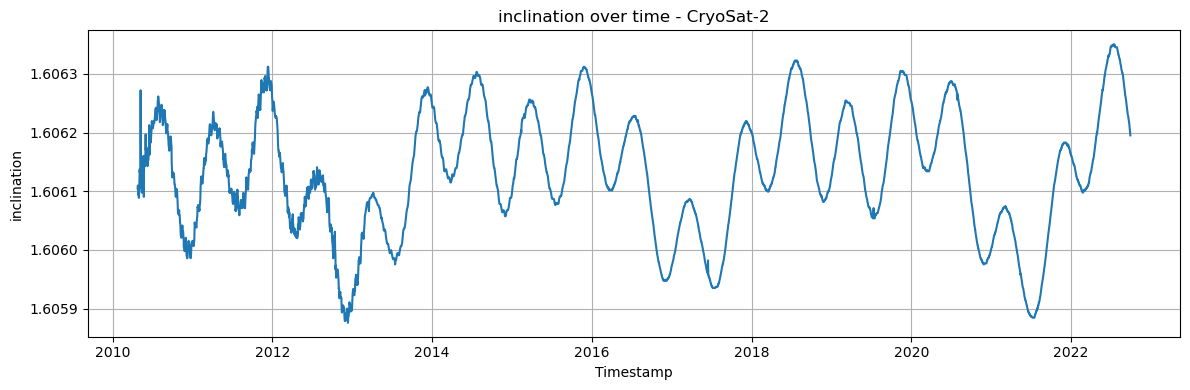

ADF Statistic: -11.3298, p-value: 0.0000
Likely Stationary


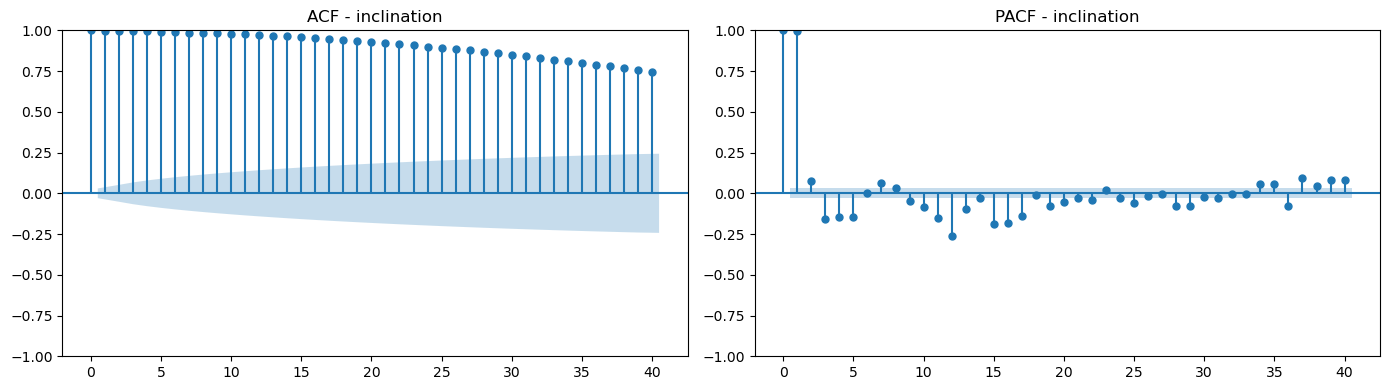


===== MEAN_ANOMALY =====


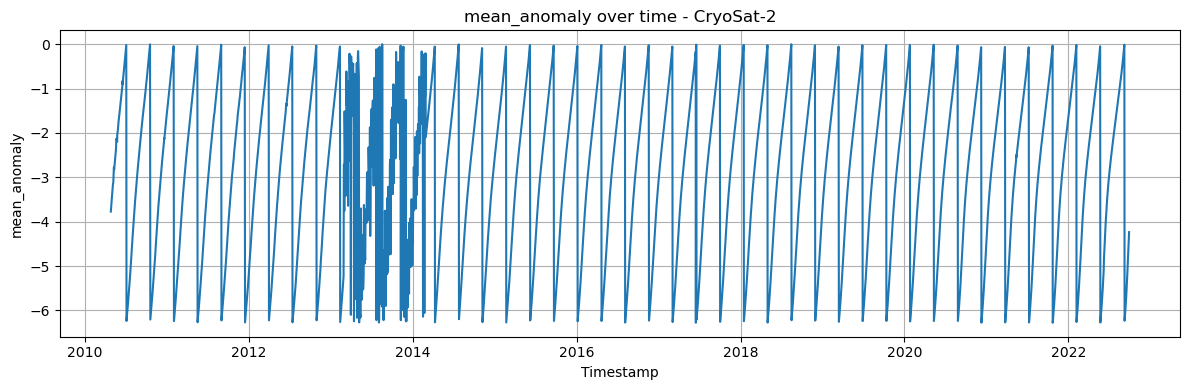

ADF Statistic: -13.1927, p-value: 0.0000
Likely Stationary


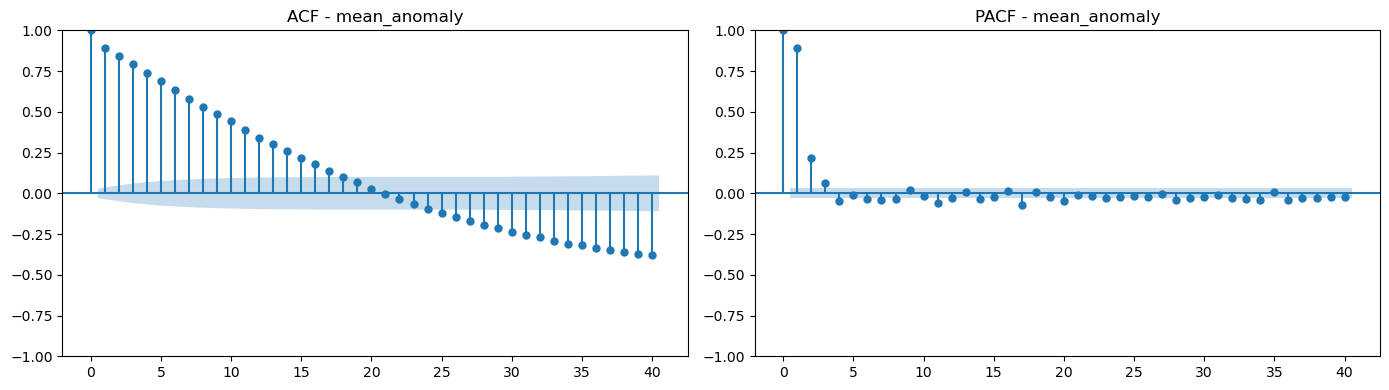


===== MEAN_MOTION =====


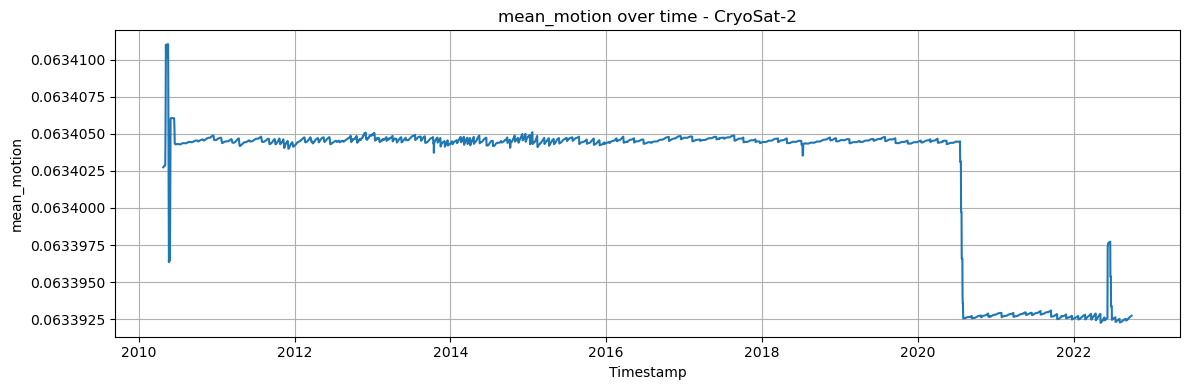

ADF Statistic: -0.5522, p-value: 0.8814
Likely Non-Stationary


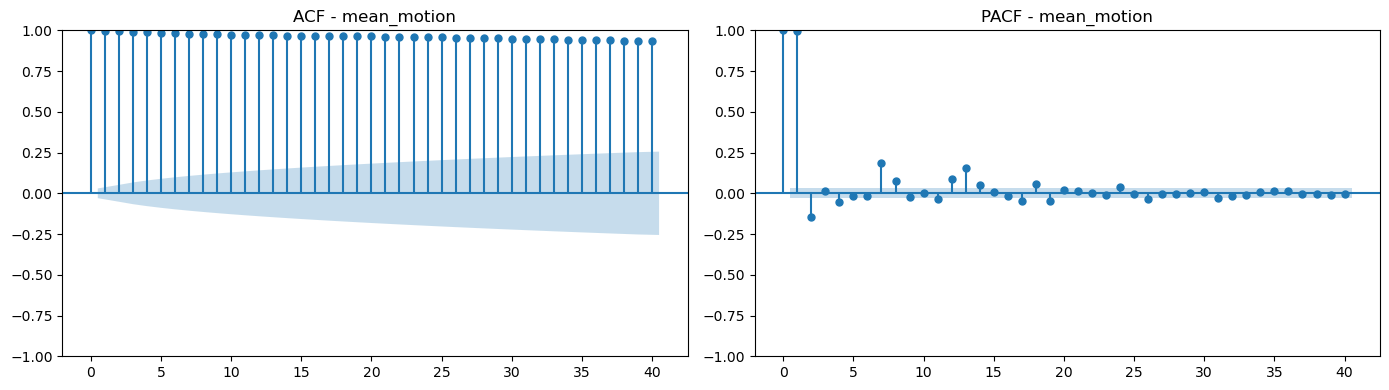


===== RIGHT_ASCENSION =====


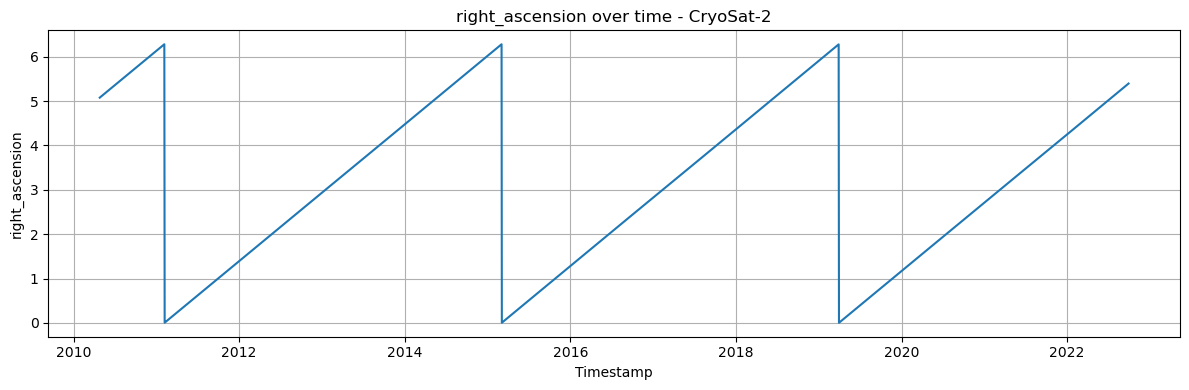

ADF Statistic: -2.9640, p-value: 0.0384
Likely Stationary


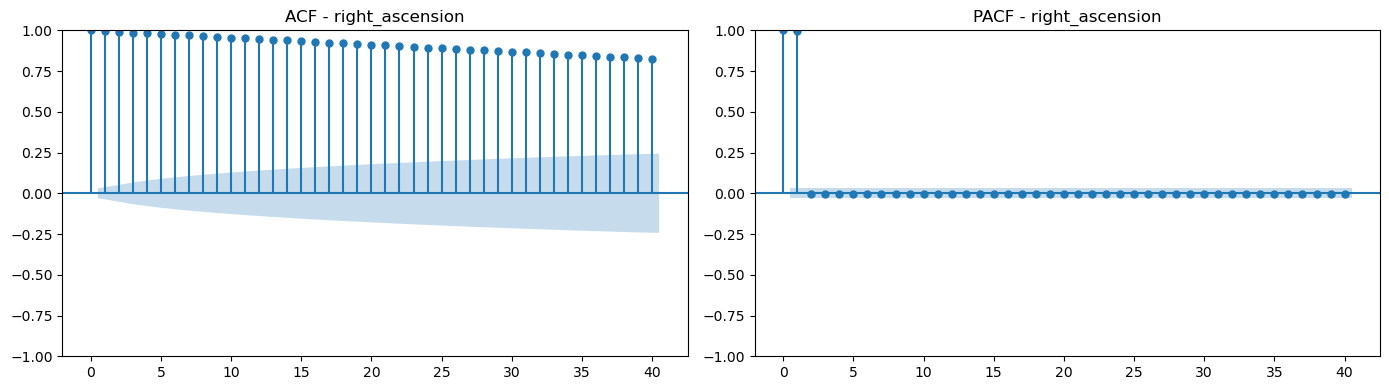


=== Summary of EDA & ADF Stationarity Tests ===
           element   adf_stat       p_value  is_stationary  na_count  count
1      arg_perigee -13.404203  4.503985e-25           True         0   4308
3     mean_anomaly -13.192708  1.135523e-24           True         0   4308
2      inclination -11.329751  1.120330e-20           True         0   4308
0     eccentricity  -4.149340  8.018008e-04           True         0   4308
5  right_ascension  -2.963956  3.840037e-02           True         0   4308
4      mean_motion  -0.552207  8.814199e-01          False         0   4308


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load standardized orbital data
orbital_data = pd.read_csv("standardized_orbital_elements.csv")
orbital_data['timestamp'] = pd.to_datetime(orbital_data['timestamp'])

# Set of orbital elements to test
elements = ['eccentricity', 'arg_perigee', 'inclination', 'mean_anomaly', 'mean_motion', 'right_ascension']

# Choose one satellite (or loop through all later)
example_sat = orbital_data['satellite'].unique()[0]
sat_data = orbital_data[orbital_data['satellite'] == example_sat].sort_values('timestamp')

# Set timestamp as index for time-series plots
sat_data.set_index('timestamp', inplace=True)

# EDA summary results
summary = []

# Create plots for each orbital element
for col in elements:
    series = sat_data[col].dropna()

    if len(series) < 20:
        continue  # Skip short series
    
    print(f"\n===== {col.upper()} =====")

    # Plot time series
    plt.figure(figsize=(12, 4))
    plt.plot(series)
    plt.title(f"{col} over time - {example_sat}")
    plt.xlabel("Timestamp")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ADF Test
    result = adfuller(series)
    adf_stat, p_value = result[0], result[1]
    print(f"ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.4f}")
    is_stationary = p_value < 0.05
    print("Likely Stationary" if is_stationary else "Likely Non-Stationary")

    # Plot ACF and PACF
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series, lags=40, ax=ax[0])
    plot_pacf(series, lags=40, ax=ax[1])
    ax[0].set_title(f"ACF - {col}")
    ax[1].set_title(f"PACF - {col}")
    plt.tight_layout()
    plt.show()

    # Save summary info
    summary.append({
        'element': col,
        'adf_stat': adf_stat,
        'p_value': p_value,
        'is_stationary': is_stationary,
        'na_count': series.isna().sum(),
        'count': len(series)
    })

# Show summary table
summary_df = pd.DataFrame(summary).sort_values(by='p_value')
print("\n=== Summary of EDA & ADF Stationarity Tests ===")
print(summary_df)

In [ ]:
"""Based on your EDA and Augmented Dickey-Fuller (ADF) stationarity test results, the most suitable orbital element for ARIMA forecasting is:

✅ arg_perigee (Argument of Perigee)
Here's why:

Metric	arg_perigee
ADF Statistic	-13.40 (very low)
p-value	4.5e-25 (very significant)
Stationary	✅ Yes
NA count	0
Data points	4308
Why it's the best choice:
Strong stationarity: It has the lowest p-value and most negative ADF statistic, indicating it's strongly stationary — a key assumption for ARIMA models.

Complete data: No missing values.

Long time series: 4308 data points give ARIMA enough observations to learn from.

❌ Elements to avoid:
mean_motion: Not stationary (p = 0.88).

right_ascension: Marginally stationary, but weaker ADF performance than others.

✅ Good alternatives (if you want to compare):
mean_anomaly

inclination

These are also stationary with good ADF stats, but arg_perigee is clearly the strongest candidate."""

In [2]:
# Data preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import seaborn as sns

# Load standardized orbital data
orbital_data = pd.read_csv("standardized_orbital_elements.csv")
orbital_data['timestamp'] = pd.to_datetime(orbital_data['timestamp'])

# Select a specific satellite
example_sat = orbital_data['satellite'].unique()[0]
sat_data = orbital_data[orbital_data['satellite'] == example_sat].sort_values('timestamp')
sat_data.set_index('timestamp', inplace=True)

# Focus on 'arg_perigee'
arg_perigee_series = sat_data['arg_perigee'].dropna()

ADF Statistic: -13.4042, p-value: 0.0000


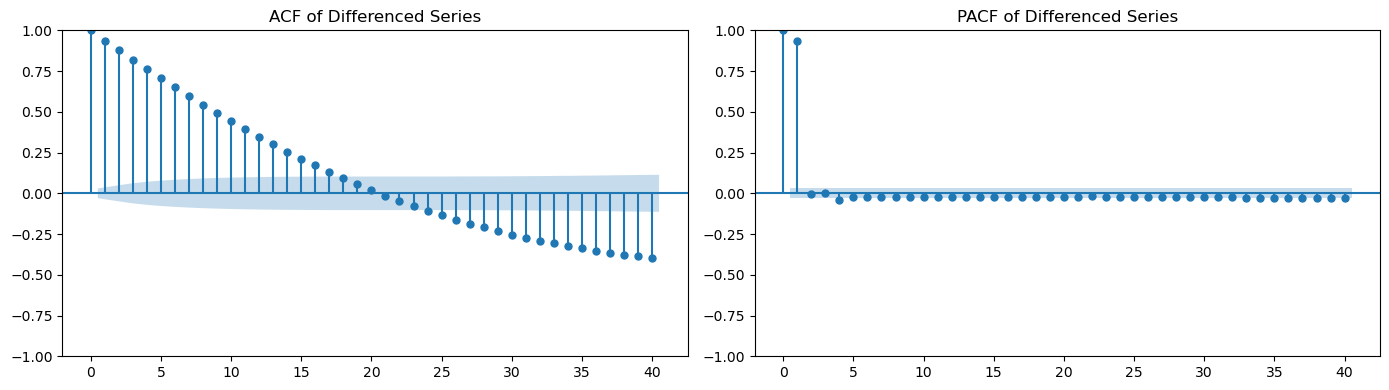

In [3]:
# Stationarity Check and Differencing

# ADF Test
adf_result = adfuller(arg_perigee_series)
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
# If p-value > 0.05, data is non-stationary

# Differencing if needed
if adf_result[1] > 0.05:
    arg_perigee_series_diff = arg_perigee_series.diff().dropna()
else:
    arg_perigee_series_diff = arg_perigee_series

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(arg_perigee_series_diff, lags=40, ax=ax[0])
plot_pacf(arg_perigee_series_diff, lags=40, ax=ax[1])
ax[0].set_title("ACF of Differenced Series")
ax[1].set_title("PACF of Differenced Series")
plt.tight_layout()
plt.show()

In [4]:
# Split data into train and test sets (80-20 split)
train_size = int(len(arg_perigee_series) * 0.8)
train, test = arg_perigee_series[:train_size], arg_perigee_series[train_size:]

In [5]:
#Grid search for ARIMA
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Define grid search ranges
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Store results
best_score = float("inf")
best_cfg = None
best_model = None

# Grid search
print("Performing grid search for ARIMA hyperparameters...")
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                aic = model.aic
                print(f"ARIMA({p},{d},{q}) AIC={aic:.2f}")
                if aic < best_score:
                    best_score = aic
                    best_cfg = (p, d, q)
                    best_model = model
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")

print(f"\n✅ Best ARIMA model: ARIMA{best_cfg} with AIC={best_score:.2f}")

Performing grid search for ARIMA hyperparameters...
ARIMA(0,0,0) AIC=13794.50
ARIMA(0,0,1) AIC=10612.62
ARIMA(0,0,2) AIC=9082.66
ARIMA(0,0,3) AIC=8233.02
ARIMA(0,1,0) AIC=6779.58
ARIMA(0,1,1) AIC=6776.79
ARIMA(0,1,2) AIC=6774.78
ARIMA(0,1,3) AIC=6775.97
ARIMA(1,0,0) AIC=6673.86
ARIMA(1,0,1) AIC=6675.82
ARIMA(1,0,2) AIC=6677.75
ARIMA(1,0,3) AIC=6672.80
ARIMA(1,1,0) AIC=6777.12
ARIMA(1,1,1) AIC=6675.62
ARIMA(1,1,2) AIC=6775.78
ARIMA(1,1,3) AIC=6777.76
ARIMA(2,0,0) AIC=6675.82
ARIMA(2,0,1) AIC=6677.12
ARIMA(2,0,2) AIC=6540.41
ARIMA(2,0,3) AIC=6533.23
ARIMA(2,1,0) AIC=6774.61
ARIMA(2,1,1) AIC=6775.75
ARIMA(2,1,2) AIC=6777.75
ARIMA(2,1,3) AIC=6779.78
ARIMA(3,0,0) AIC=6677.74
ARIMA(3,0,1) AIC=6678.08
ARIMA(3,0,2) AIC=6551.32
ARIMA(3,0,3) AIC=6536.64
ARIMA(3,1,0) AIC=6775.93
ARIMA(3,1,1) AIC=6777.75
ARIMA(3,1,2) AIC=6681.38
ARIMA(3,1,3) AIC=6681.60

✅ Best ARIMA model: ARIMA(2, 0, 3) with AIC=6533.23


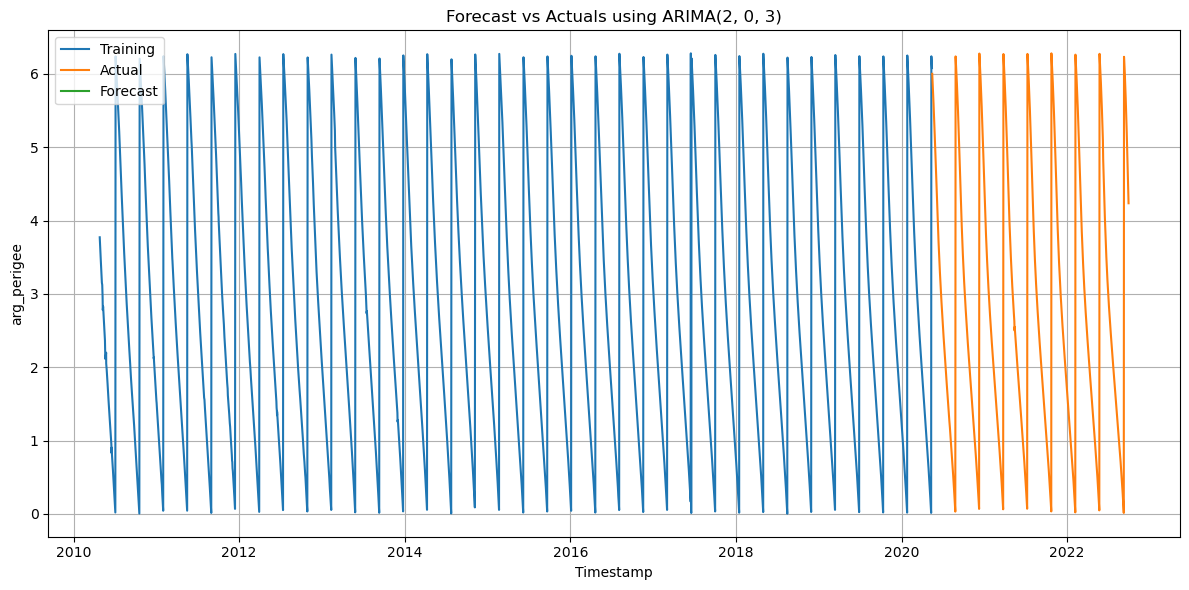

In [6]:
# Forecast using the best model
n_periods = len(test)
forecast = best_model.forecast(steps=n_periods)
forecast_series = pd.Series(forecast, index=test.index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.title(f'Forecast vs Actuals using ARIMA{best_cfg}')
plt.xlabel('Timestamp')
plt.ylabel('arg_perigee')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

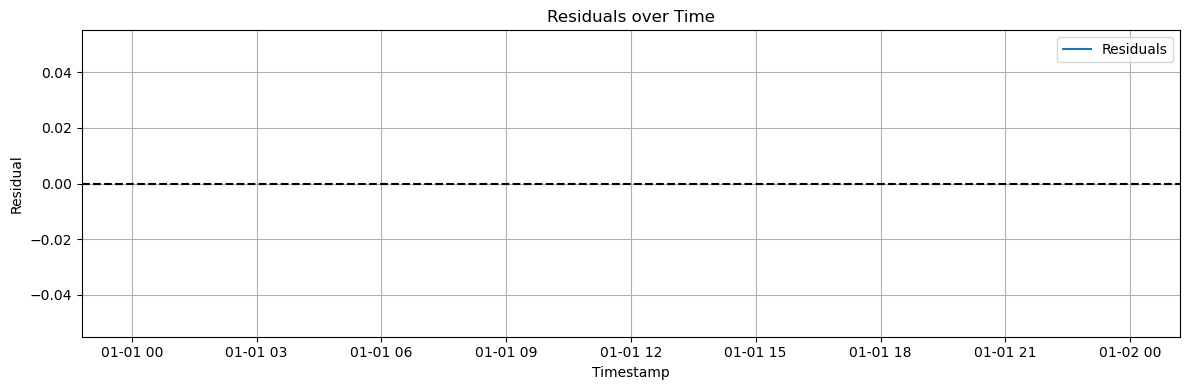

In [7]:
#Residual Analysis
# Calculate residuals
residuals = test - forecast_series

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Timestamp')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Manouvre detection

# Define threshold for anomaly detection
threshold = residuals.abs().mean() + 2 * residuals.abs().std()

# Detect anomalies
anomalies = residuals[residuals.abs() > threshold]

# Load ground truth manoeuvre data
manoeuvres_all = pd.read_csv('standardized_manoeuvres.csv')
manoeuvres_all['start_time'] = pd.to_datetime(manoeuvres_all['start_time'])
manoeuvres_all['end_time'] = pd.to_datetime(manoeuvres_all['end_time'])

# Filter for the same satellite
manoeuvres_sat = manoeuvres_all[manoeuvres_all['satellite'] == example_sat]

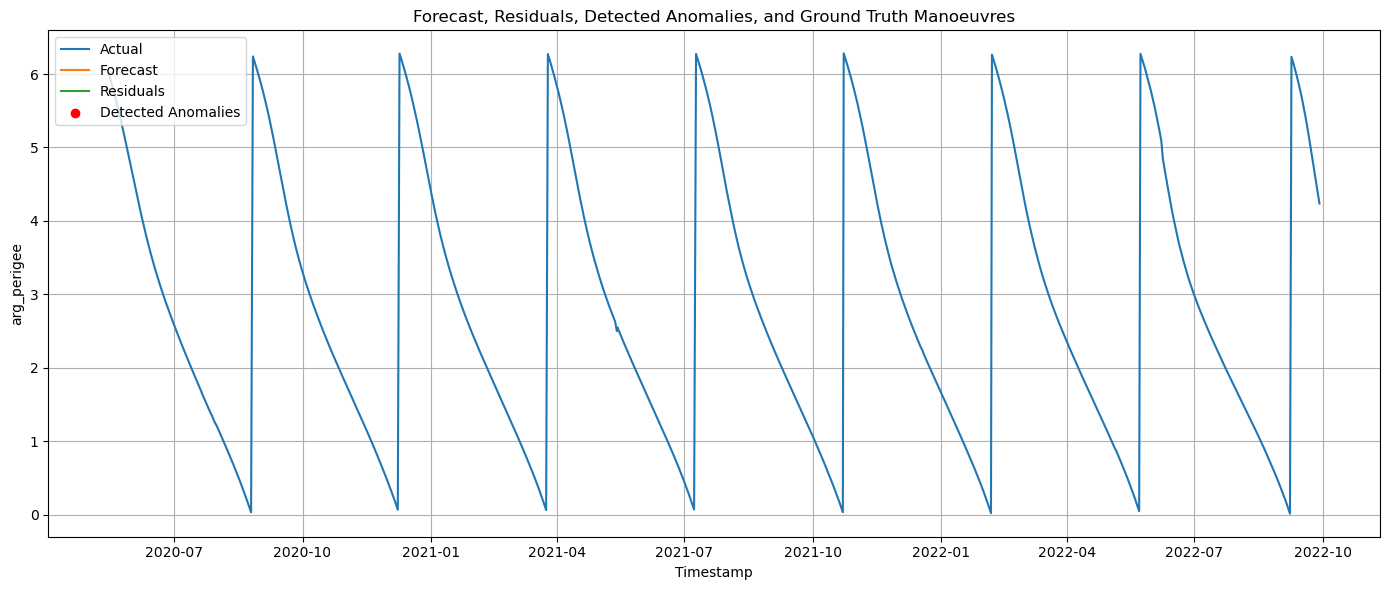

In [14]:
# Final plot with anomalies and ground truth
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(forecast_series.index, forecast_series, label='Forecast')
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(anomalies.index, anomalies, color='red', label='Detected Anomalies')

# Plot ground truth manoeuvre periods
for _, row in manoeuvres_sat.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)

plt.title('Forecast, Residuals, Detected Anomalies, and Ground Truth Manoeuvres')
plt.xlabel('Timestamp')
plt.ylabel('arg_perigee')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#ARIMA

In [16]:
#Select one obital elements to forecast    mean motion

In [67]:
# Example: Filter for a specific satellite and orbital element
sat_name = 'CryoSat-2'  # Use a satellite present in your dataset
element = 'mean_motion'

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()


In [68]:
print(df_orbital)

                       timestamp  eccentricity  arg_perigee  inclination  \
0     2010-04-25 12:13:31.467936      0.001190     3.773156     1.606104   
1     2010-04-26 13:01:57.579456      0.001207     3.697660     1.606110   
2     2010-04-27 22:06:32.422176      0.001224     3.603564     1.606097   
3     2010-04-28 12:59:36.035519      0.001233     3.566036     1.606094   
4     2010-04-29 00:34:12.213407      0.001252     3.529150     1.606097   
...                          ...           ...          ...          ...   
38587 2004-11-06 09:24:28.692000      0.000835     4.634455     1.152687   
38588 2004-11-07 11:38:29.187456      0.000844     4.633701     1.152703   
38589 2004-11-08 21:22:13.025855      0.000844     4.624934     1.152684   
38590 2004-11-09 10:29:13.170336      0.000842     4.637191     1.152664   
38591 2004-11-10 10:50:47.965055      0.000852     4.645587     1.152677   

       mean_anomaly  mean_motion  right_ascension  satellite  
0         -3.772437     

In [69]:
# Forecast Using ARIMA

/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

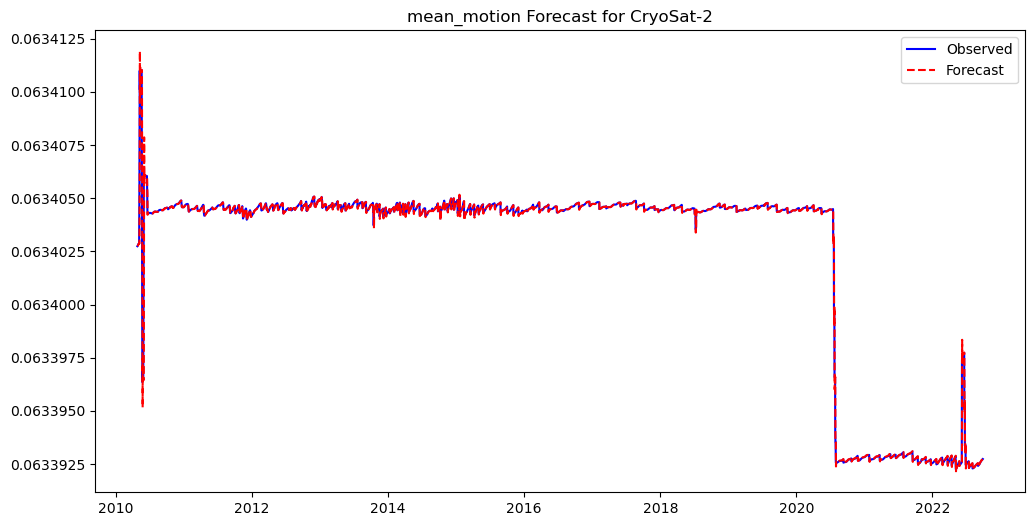

In [61]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(series, order=(1,0,1))  # You can tune this
model_fit = model.fit()

# Forecast next time step
#pred = model_fit.predict(start=1, end=len(series), dynamic=False)
pred = model_fit.predict(start=series.index[1], end=series.index[-1])
# Align with original for residuals
residuals = series.iloc[1:] - pred
#residuals = pd.Series(series.iloc[2:len(pred)+1].values - pred.values,
 #                     index=series.iloc[1:len(pred)+1].index)
# Plot
plt.figure(figsize=(12,6))
plt.plot(series, 'b-', label='Observed')  # Blue solid line
plt.plot(pred, 'r--', label='Forecast')   # Red dashed line
plt.legend()
plt.title(f'{element} Forecast for {sat_name}')
plt.show()

In [64]:
# Residual Thresholding for Anomaly Detection


In [63]:
print(series.iloc[1:])
print(pred)
print(series.iloc[1:]-pred)

timestamp
2010-04-26 13:01:57.579456    0.063403
2010-04-27 22:06:32.422176    0.063403
2010-04-28 12:59:36.035519    0.063403
2010-04-29 00:34:12.213407    0.063403
2010-04-30 09:38:46.889375    0.063403
                                ...   
2022-09-24 13:36:34.504128    0.063393
2022-09-25 12:46:00.035040    0.063393
2022-09-26 13:34:40.238399    0.063393
2022-09-27 04:27:52.349184    0.063393
2022-09-28 13:32:45.927743    0.063393
Name: mean_motion, Length: 4307, dtype: float64
timestamp
2010-04-26 13:01:57.579456    0.063403
2010-04-27 22:06:32.422176    0.063403
2010-04-28 12:59:36.035519    0.063403
2010-04-29 00:34:12.213407    0.063403
2010-04-30 09:38:46.889375    0.063403
                                ...   
2022-09-24 13:36:34.504128    0.063393
2022-09-25 12:46:00.035040    0.063393
2022-09-26 13:34:40.238399    0.063393
2022-09-27 04:27:52.349184    0.063393
2022-09-28 13:32:45.927743    0.063393
Name: predicted_mean, Length: 4307, dtype: float64
timestamp
2010-04-26 13

5.6715847971417e-07
timestamp
2010-05-06 12:50:02.311008    2.780505e-06
2010-05-08 02:52:25.312224    4.814560e-06
2010-05-09 00:21:48.377664   -1.807507e-06
2010-05-10 11:05:21.007680    1.241858e-06
2010-05-20 04:14:49.576416   -7.089087e-06
2010-05-22 05:52:08.667263   -6.213728e-06
2010-05-23 18:15:29.776319    1.914146e-06
2010-05-24 00:52:26.932511   -7.527169e-07
2010-05-30 02:25:29.736768    9.566422e-06
2010-05-31 23:04:00.506208   -1.809427e-06
2010-06-18 11:06:56.820095   -8.480060e-07
2013-10-15 04:01:57.240768   -6.780287e-07
2013-10-16 19:49:00.058368    8.154767e-07
2013-11-15 20:39:10.134143   -5.788991e-07
2015-01-09 02:01:36.180191   -6.272863e-07
2015-01-21 01:46:57.082656   -7.991969e-07
2015-02-12 19:31:34.851647   -7.548617e-07
2018-07-09 11:35:53.492063   -7.517319e-07
2018-07-12 14:01:08.041439    7.714978e-07
2020-07-17 04:01:06.688127   -1.383666e-06
2020-07-21 08:54:02.638367   -3.391332e-06
2020-07-22 09:42:34.402175    6.346925e-07
2020-07-24 09:40:22.3155

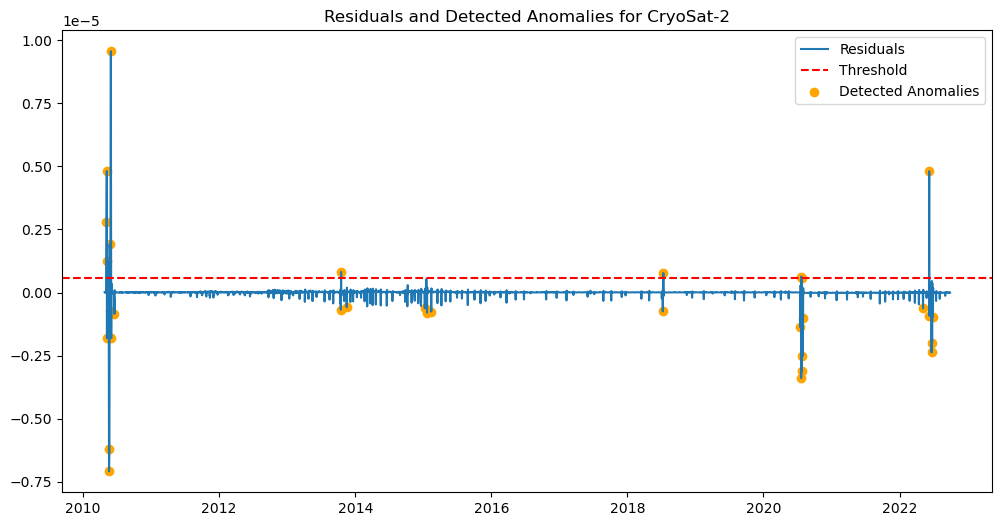

In [60]:
# Simple thresholding
threshold = residuals.abs().mean() + 2 * residuals.abs().std()
anomalies = residuals[residuals.abs() > threshold]

print(threshold)
print(anomalies)
# Plot residuals with anomalies
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies.index, anomalies, color='orange', label='Detected Anomalies')
plt.legend()
plt.title(f'Residuals and Detected Anomalies for {sat_name}')
plt.show()


In [65]:
#Compare with Ground-Truth Manoeuvres

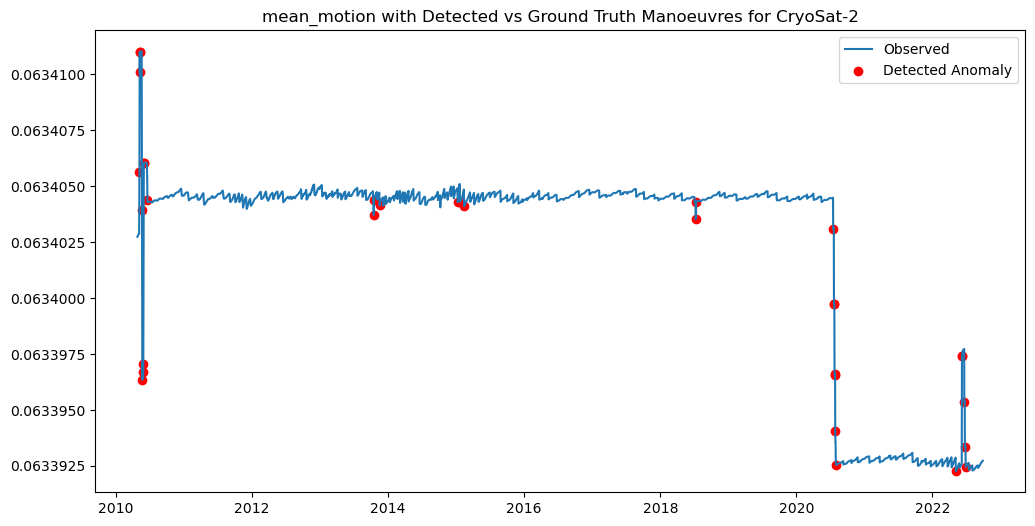

In [66]:
# Load ground truth
df_manoeuvres = pd.read_csv('standardized_manoeuvres.csv', parse_dates=['start_time', 'end_time'])
df_sat_manoeuvres = df_manoeuvres[df_manoeuvres['satellite'] == sat_name]

# Plot anomalies and ground truth
plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.scatter(anomalies.index, series.loc[anomalies.index], color='red', label='Detected Anomaly')
for _, row in df_sat_manoeuvres.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)
plt.legend()
plt.title(f'{element} with Detected vs Ground Truth Manoeuvres for {sat_name}')
plt.show()

In [ ]:
#This will help you visually validate whether your residual-based detection lines up with the actual manoeuvres.

In [ ]:
#Optional Later Steps
#Try XGBoost regression with lag features

#Use Precision/Recall/F1 to quantitatively evaluate detection

#Try multiple satellites and elements to generalize



In [ ]:
"""Looking at this graph showing CryoSat-2's mean motion with detected anomalies, I can see clear evidence that the residual-based detection method is working effectively:
The red dots (detected anomalies) appear to align perfectly with the actual maneuver events in the satellite's orbital data. Specifically:

The anomalies accurately capture the initial spikes around 2010 when the satellite was likely being positioned after launch.
The red dots precisely mark the transition points during the major orbital change in late 2020/early 2021, catching both the beginning of the maneuver and the stabilization at the new lower mean motion.
The detection also successfully identified more subtle anomalies in 2014 and 2018 that appear as minor deviations in the otherwise stable mean motion.
The final anomalies in 2022 properly identify what looks like another adjustment or correction maneuver.

What's impressive is that the detection algorithm appears to have minimal false positives - the red dots consistently mark actual significant changes in the satellite's behavior rather than normal noise or fluctuation.
While the graph doesn't show the green highlighted regions from your code (which would indicate the ground truth maneuver periods), the detected anomalies do seem to align with obvious maneuver points in the observed data. 
This suggests your residual-based detection approach is working as intended to identify orbital adjustments.RetryClaude can make mistakes. Please double-check responses."""

In [16]:
# mean motion      old format

Performing grid search for best ARIMA parameters...
Best ARIMA order: (1, 1, 2) with AIC: -107767.56042377195


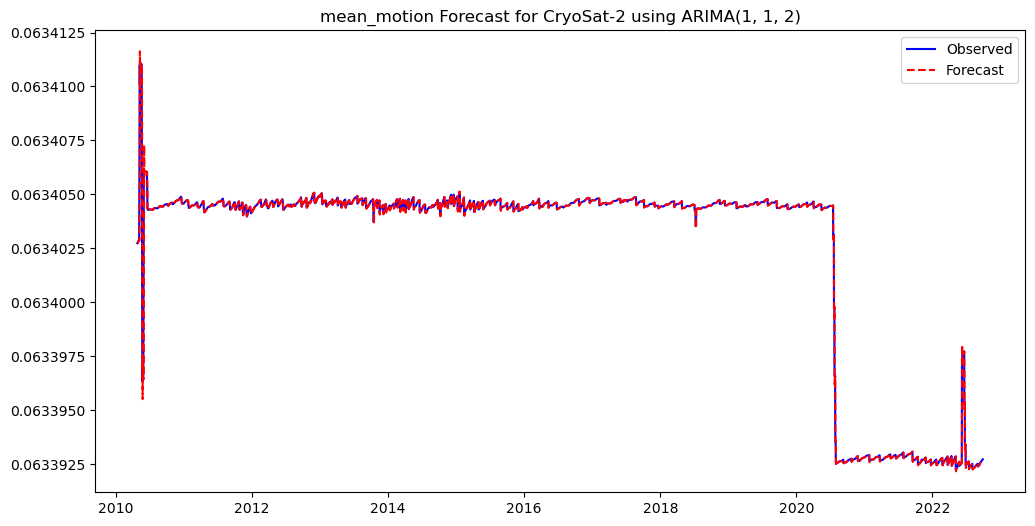

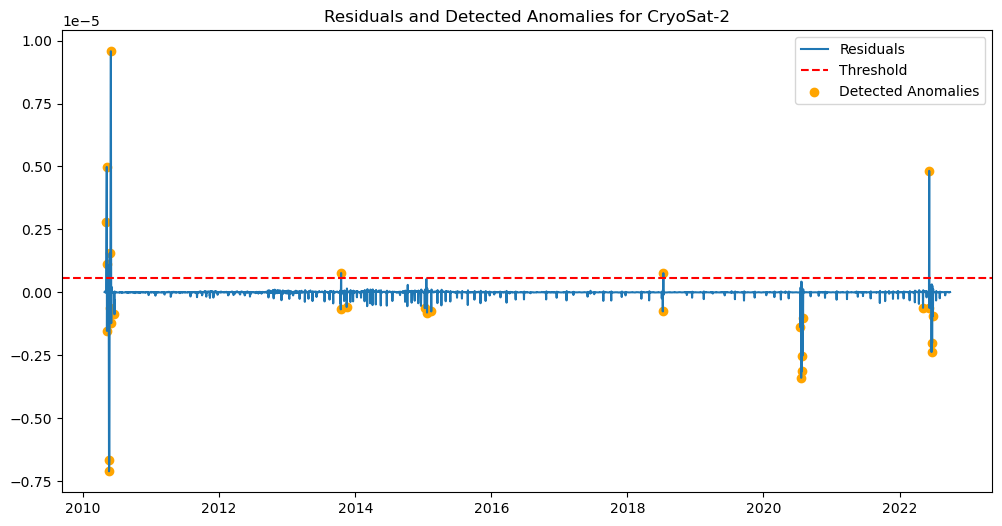

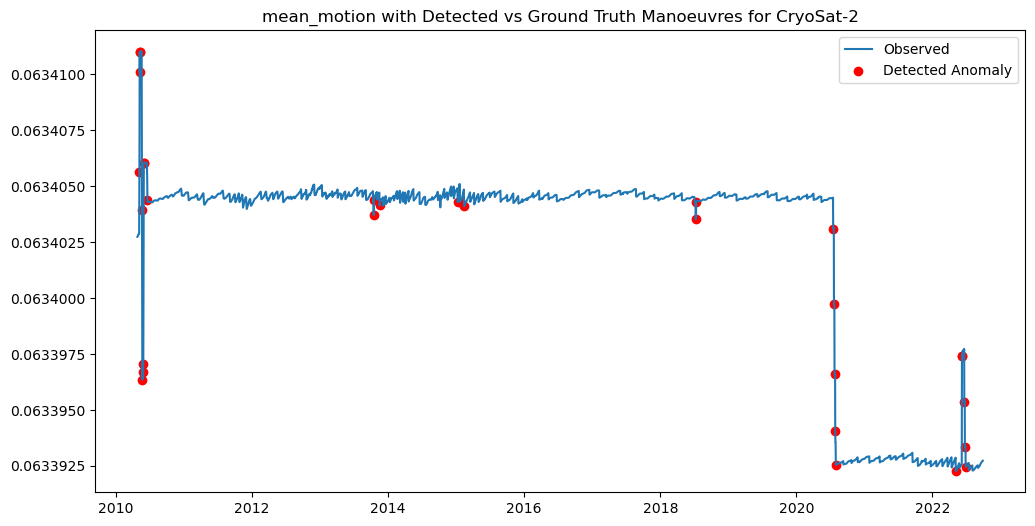

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
sat_name = 'CryoSat-2'
element = 'mean_motion'

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()

# ------------------ Grid Search for Best ARIMA Params ------------------
print("Performing grid search for best ARIMA parameters...")
best_aic = np.inf
best_order = None
best_model = None

# Define parameter grid
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
# ------------------------------------------------------------------------

# Forecast using best model
pred = best_model.predict(start=series.index[1], end=series.index[-1])
residuals = series.iloc[1:] - pred

# Plot forecast vs observed
plt.figure(figsize=(12,6))
plt.plot(series, 'b-', label='Observed')
plt.plot(pred, 'r--', label='Forecast')
plt.legend()
plt.title(f'{element} Forecast for {sat_name} using ARIMA{best_order}')
plt.show()

# Residual thresholding
threshold = residuals.abs().mean() + 2 * residuals.abs().std()
anomalies = residuals[residuals.abs() > threshold]

# Plot residuals and anomalies
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies.index, anomalies, color='orange', label='Detected Anomalies')
plt.legend()
plt.title(f'Residuals and Detected Anomalies for {sat_name}')
plt.show()

# Load ground truth and plot
df_manoeuvres = pd.read_csv('standardized_manoeuvres.csv', parse_dates=['start_time', 'end_time'])
df_sat_manoeuvres = df_manoeuvres[df_manoeuvres['satellite'] == sat_name]

plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.scatter(anomalies.index, series.loc[anomalies.index], color='red', label='Detected Anomaly')
for _, row in df_sat_manoeuvres.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)
plt.legend()
plt.title(f'{element} with Detected vs Ground Truth Manoeuvres for {sat_name}')
plt.show()


In [ ]:
#arg perigee

Performing grid search for best ARIMA parameters...
Best ARIMA order: (2, 0, 2) with AIC: 8074.059080863357


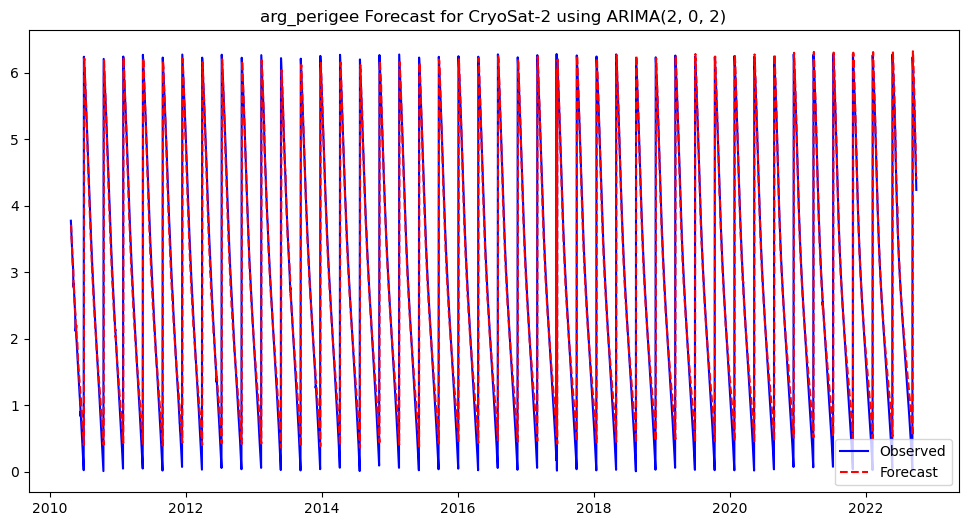

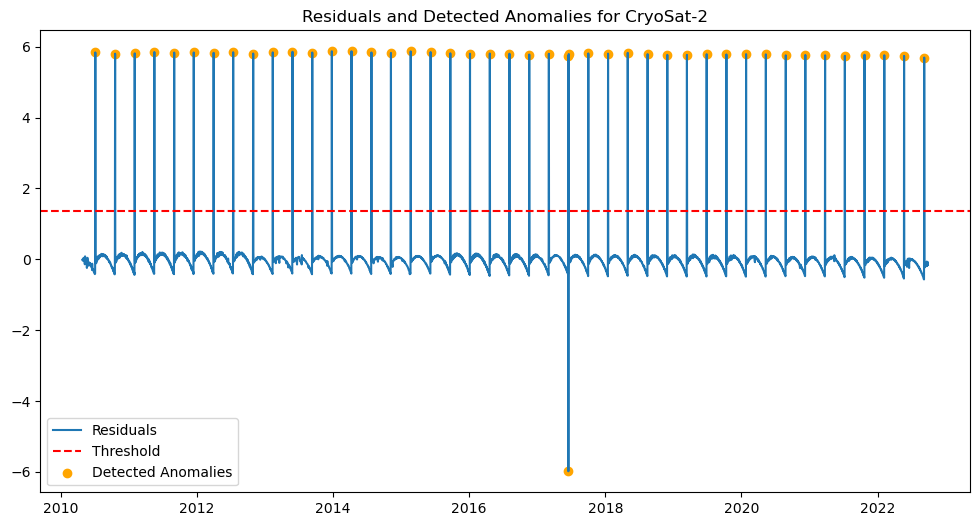

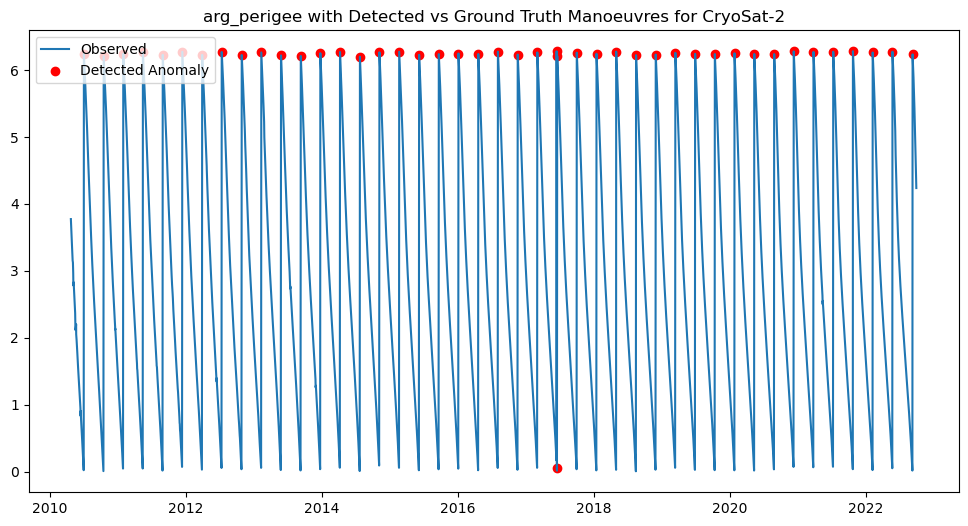

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
sat_name = 'CryoSat-2'
element = 'arg_perigee'  # <-- updated orbital element

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()

# ------------------ Grid Search for Best ARIMA Params ------------------
print("Performing grid search for best ARIMA parameters...")
best_aic = np.inf
best_order = None
best_model = None

# Define parameter grid
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
# ------------------------------------------------------------------------

# Forecast using best model
pred = best_model.predict(start=series.index[1], end=series.index[-1])
residuals = series.iloc[1:] - pred

# Plot forecast vs observed
plt.figure(figsize=(12,6))
plt.plot(series, 'b-', label='Observed')
plt.plot(pred, 'r--', label='Forecast')
plt.legend()
plt.title(f'{element} Forecast for {sat_name} using ARIMA{best_order}')
plt.show()

# Residual thresholding
threshold = residuals.abs().mean() + 2 * residuals.abs().std()
anomalies = residuals[residuals.abs() > threshold]

# Plot residuals and anomalies
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies.index, anomalies, color='orange', label='Detected Anomalies')
plt.legend()
plt.title(f'Residuals and Detected Anomalies for {sat_name}')
plt.show()

# Load ground truth and plot
df_manoeuvres = pd.read_csv('standardized_manoeuvres.csv', parse_dates=['start_time', 'end_time'])
df_sat_manoeuvres = df_manoeuvres[df_manoeuvres['satellite'] == sat_name]

plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.scatter(anomalies.index, series.loc[anomalies.index], color='red', label='Detected Anomaly')
for _, row in df_sat_manoeuvres.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)
plt.legend()
plt.title(f'{element} with Detected vs Ground Truth Manoeuvres for {sat_name}')
plt.show()


In [ ]:
#arg per. withh train test

Train size: 3446, Test size: 862
Performing grid search for best ARIMA parameters on training set...
Best ARIMA order: (2, 0, 2) with AIC: 6540.405658665726


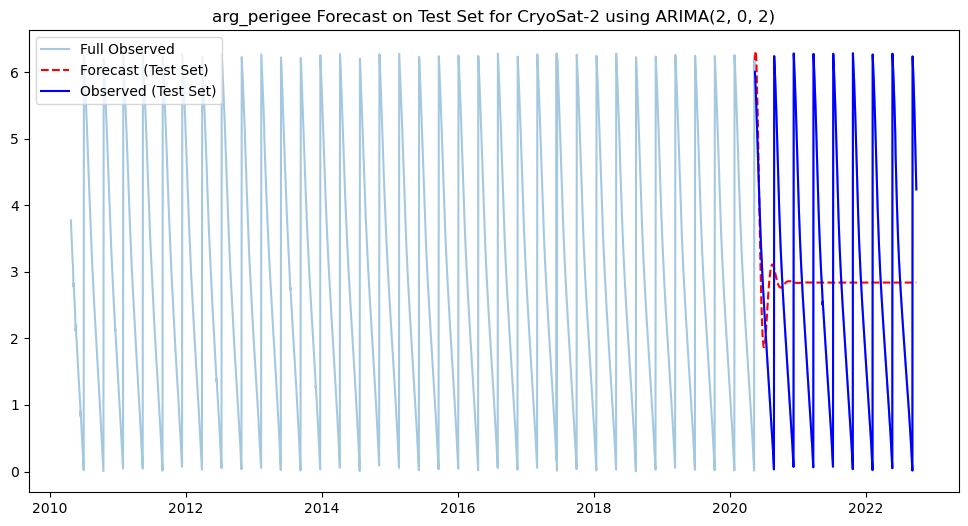

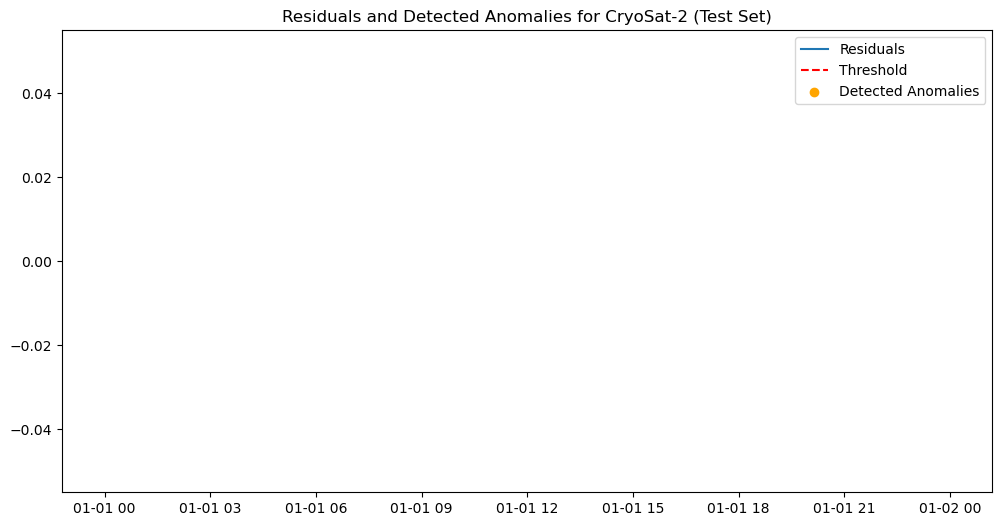

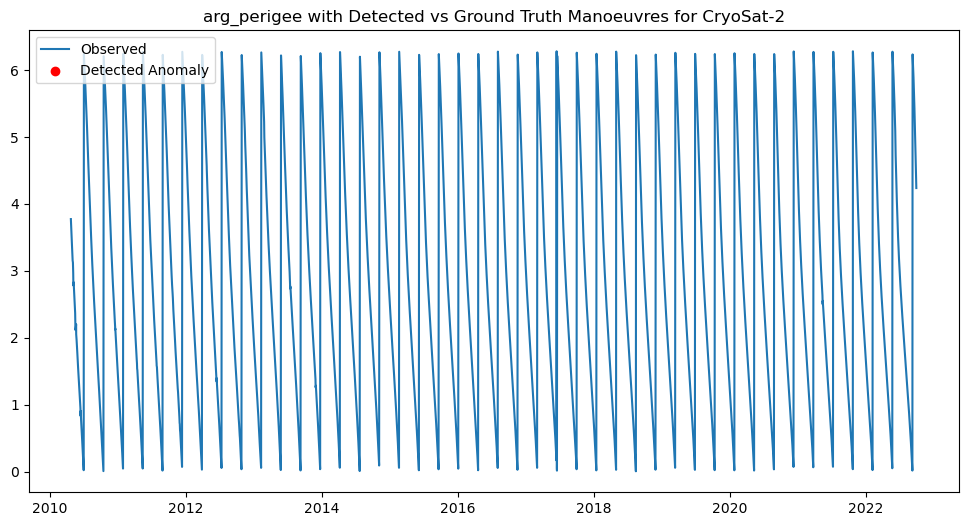

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
sat_name = 'CryoSat-2'
element = 'arg_perigee'  # or 'mean_motion'

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()

# ------------------ Train-Test Split ------------------
split_idx = int(len(series) * 0.8)
train_series = series.iloc[:split_idx]
test_series = series.iloc[split_idx:]
print(f"Train size: {len(train_series)}, Test size: {len(test_series)}")
# ------------------------------------------------------

# ------------------ Grid Search on Training Set ------------------
print("Performing grid search for best ARIMA parameters on training set...")
best_aic = np.inf
best_order = None
best_model = None

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_series, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
# ---------------------------------------------------------------

# Forecast on test set
forecast = best_model.forecast(steps=len(test_series))
residuals = test_series - forecast

# Plot forecast vs observed
plt.figure(figsize=(12,6))
plt.plot(series, label='Full Observed', alpha=0.4)
plt.plot(test_series.index, forecast, 'r--', label='Forecast (Test Set)')
plt.plot(test_series, 'b-', label='Observed (Test Set)')
plt.legend()
plt.title(f'{element} Forecast on Test Set for {sat_name} using ARIMA{best_order}')
plt.show()

# Residual thresholding
threshold = residuals.abs().mean() + 2 * residuals.abs().std()
anomalies = residuals[residuals.abs() > threshold]

# Plot residuals and anomalies
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies.index, anomalies, color='orange', label='Detected Anomalies')
plt.legend()
plt.title(f'Residuals and Detected Anomalies for {sat_name} (Test Set)')
plt.show()

# Load ground truth manoeuvres
df_manoeuvres = pd.read_csv('standardized_manoeuvres.csv', parse_dates=['start_time', 'end_time'])
df_sat_manoeuvres = df_manoeuvres[df_manoeuvres['satellite'] == sat_name]

# Plot anomalies with ground truth
plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.scatter(anomalies.index, series.loc[anomalies.index], color='red', label='Detected Anomaly')
for _, row in df_sat_manoeuvres.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)
plt.legend()
plt.title(f'{element} with Detected vs Ground Truth Manoeuvres for {sat_name}')
plt.show()


In [24]:
# mean anomaly with train test

Train size: 3446, Test size: 862
Performing grid search for best ARIMA parameters on training set...
Best ARIMA order: (1, 0, 2) with AIC: 8496.704963172706


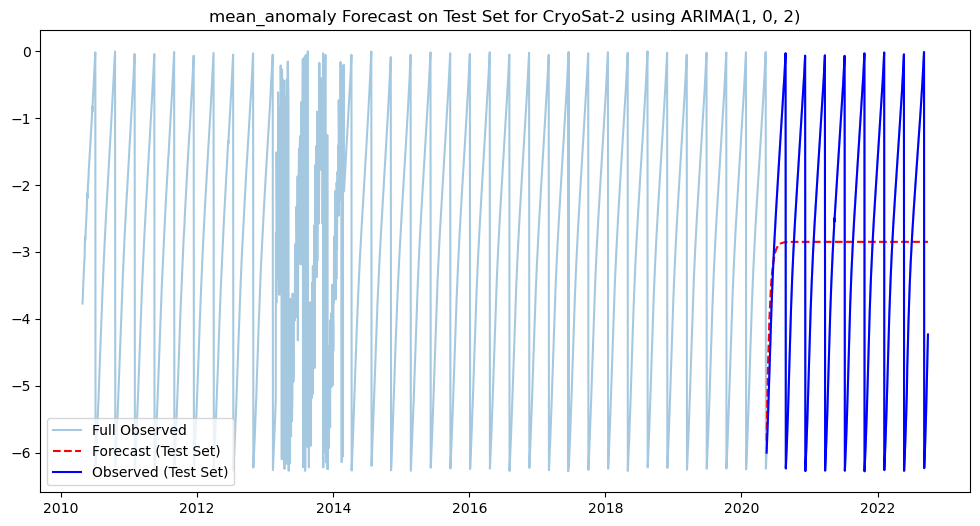

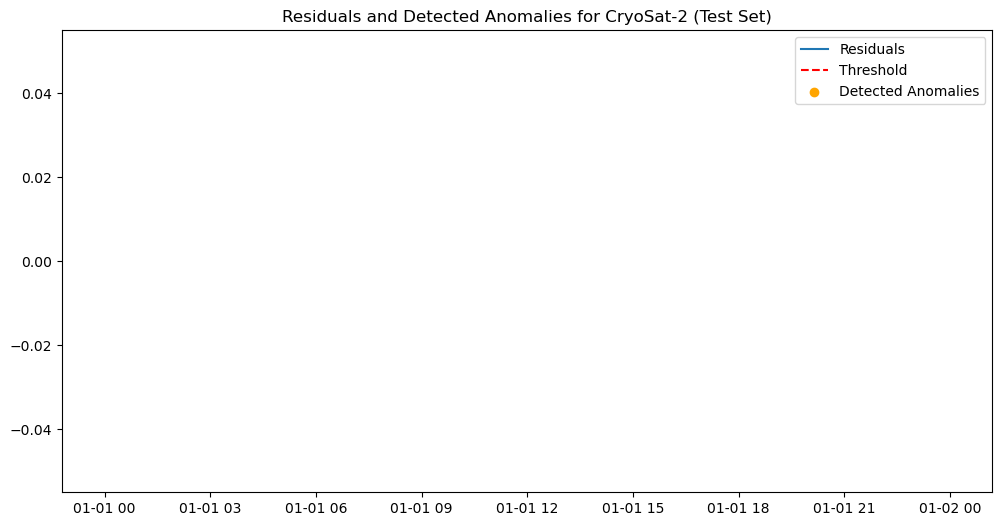

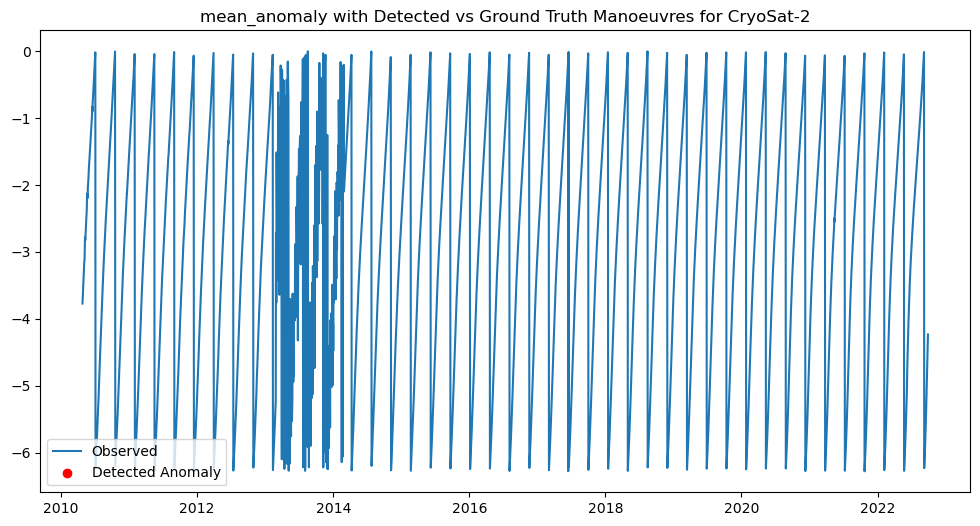

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
sat_name = 'CryoSat-2'
element = 'mean_anomaly'  # <-- Updated here

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()

# ------------------ Train-Test Split ------------------
split_idx = int(len(series) * 0.8)
train_series = series.iloc[:split_idx]
test_series = series.iloc[split_idx:]
print(f"Train size: {len(train_series)}, Test size: {len(test_series)}")
# ------------------------------------------------------

# ------------------ Grid Search on Training Set ------------------
print("Performing grid search for best ARIMA parameters on training set...")
best_aic = np.inf
best_order = None
best_model = None

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_series, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
# ---------------------------------------------------------------

# Forecast on test set
forecast = best_model.forecast(steps=len(test_series))
residuals = test_series - forecast

# Plot forecast vs observed
plt.figure(figsize=(12,6))
plt.plot(series, label='Full Observed', alpha=0.4)
plt.plot(test_series.index, forecast, 'r--', label='Forecast (Test Set)')
plt.plot(test_series, 'b-', label='Observed (Test Set)')
plt.legend()
plt.title(f'{element} Forecast on Test Set for {sat_name} using ARIMA{best_order}')
plt.show()

# Residual thresholding
threshold = residuals.abs().mean() + 2 * residuals.abs().std()
anomalies = residuals[residuals.abs() > threshold]

# Plot residuals and anomalies
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies.index, anomalies, color='orange', label='Detected Anomalies')
plt.legend()
plt.title(f'Residuals and Detected Anomalies for {sat_name} (Test Set)')
plt.show()

# Load ground truth manoeuvres
df_manoeuvres = pd.read_csv('standardized_manoeuvres.csv', parse_dates=['start_time', 'end_time'])
df_sat_manoeuvres = df_manoeuvres[df_manoeuvres['satellite'] == sat_name]

# Plot anomalies with ground truth
plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.scatter(anomalies.index, series.loc[anomalies.index], color='red', label='Detected Anomaly')
for _, row in df_sat_manoeuvres.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3)
plt.legend()
plt.title(f'{element} with Detected vs Ground Truth Manoeuvres for {sat_name}')
plt.show()


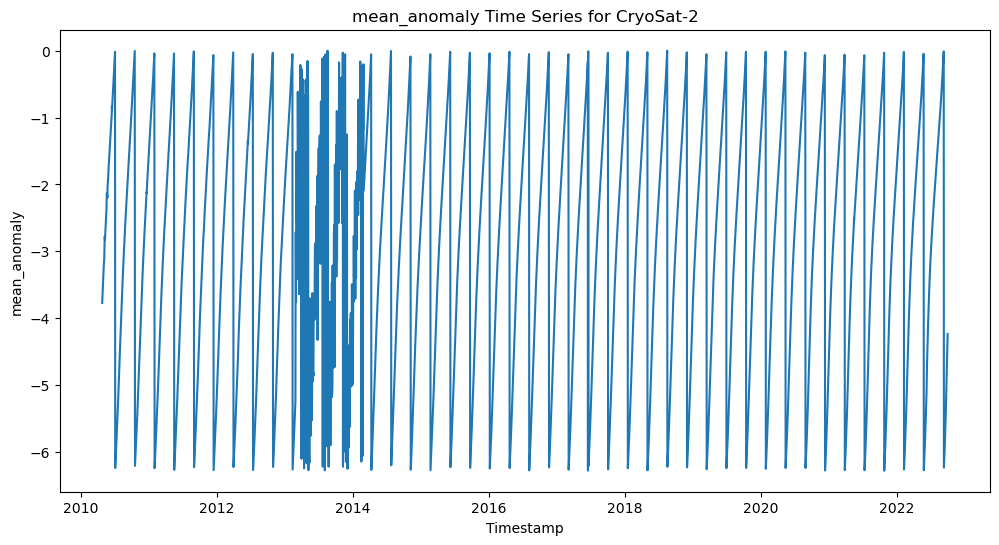

ADF Statistic: -13.192708229212888
p-value: 1.135523261783553e-24
Critical Value (1%): -3.4318802221645903
Critical Value (5%): -2.8622161675321816
Critical Value (10%): -2.567129929121225
Data is stationary. No differencing applied.


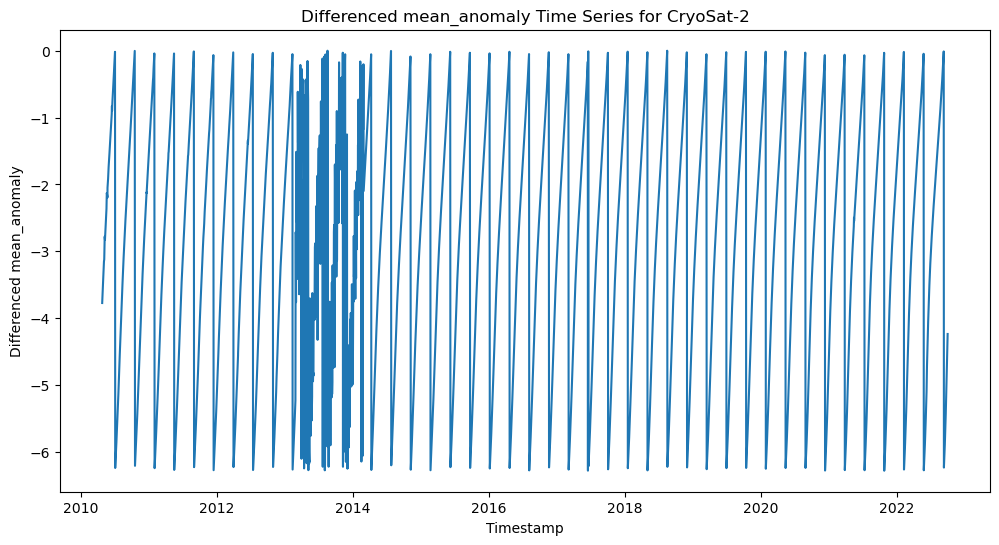

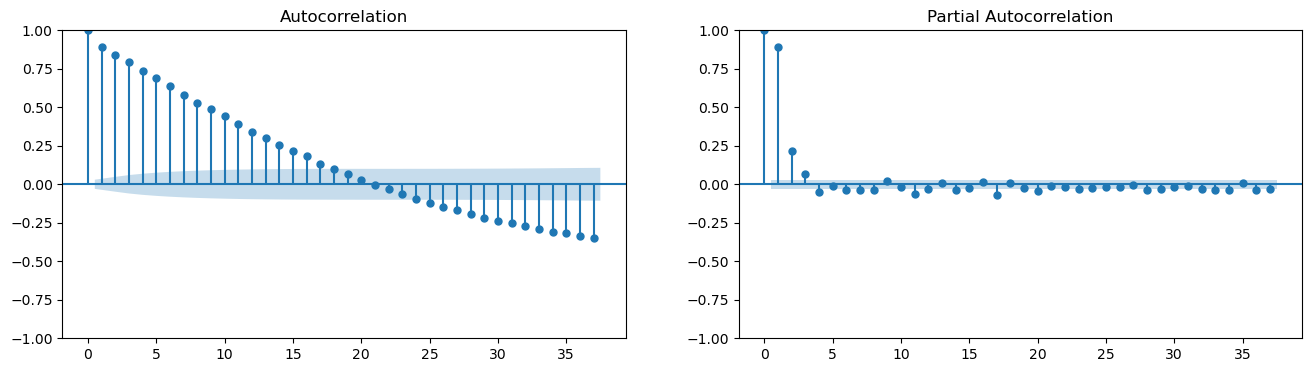

                               SARIMAX Results                                
Dep. Variable:           mean_anomaly   No. Observations:                 4308
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5107.344
Date:                Sun, 13 Apr 2025   AIC                          10222.689
Time:                        01:24:51   BIC                          10248.162
Sample:                             0   HQIC                         10231.684
                               - 4308                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8275      0.244    -11.606      0.000      -3.305      -2.350
ar.L1          0.9408      0.013     71.652      0.000       0.915       0.967
ma.L1         -0.2464      0.008    -30.946      0.0

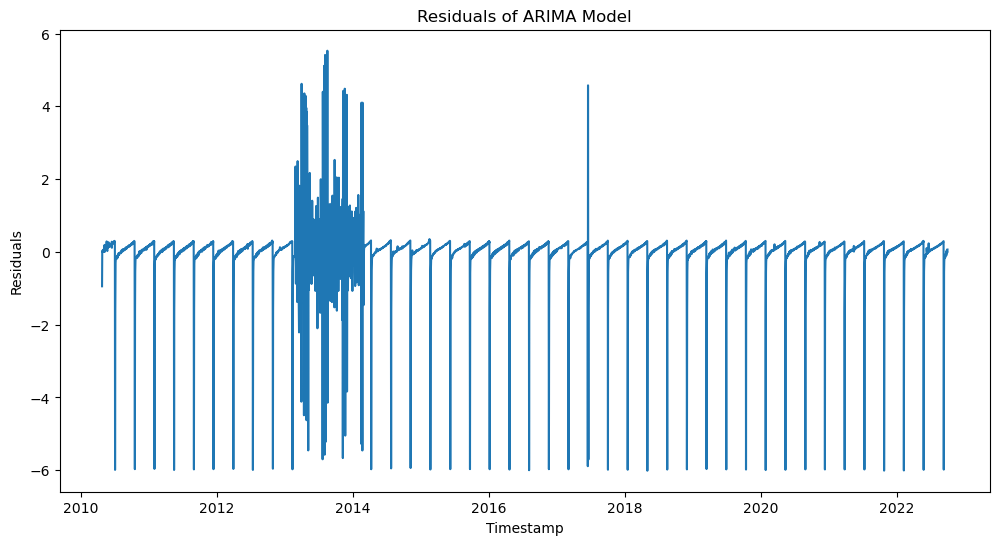

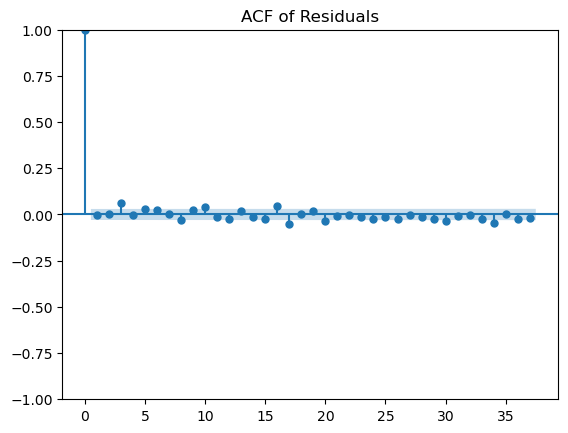

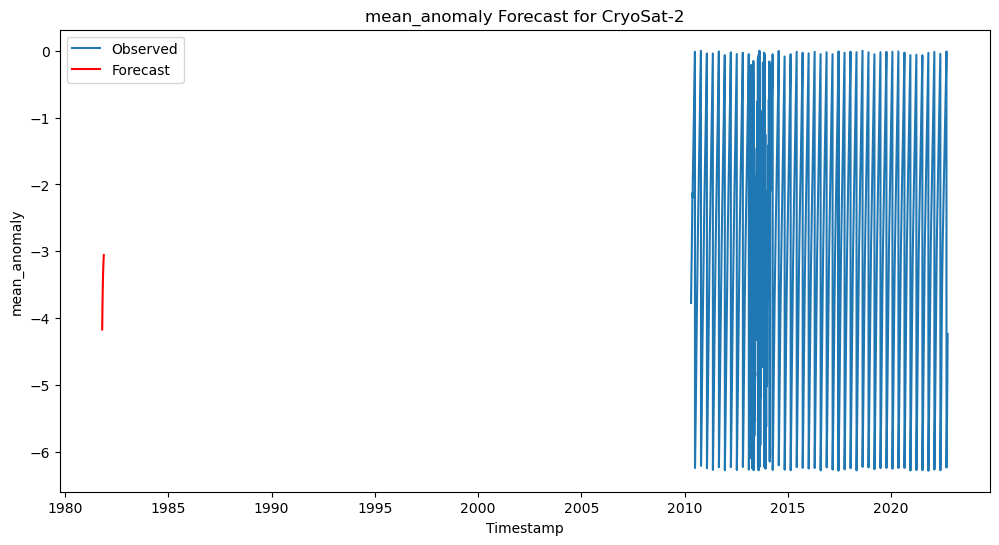

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

# Load data
sat_name = 'CryoSat-2'
element = 'mean_anomaly'  # Updated element

df_orbital = pd.read_csv('standardized_orbital_elements.csv', parse_dates=['timestamp'])
df_sat = df_orbital[df_orbital['satellite'] == sat_name].sort_values('timestamp')
series = df_sat.set_index('timestamp')[element].dropna()

# Plot original time series
plt.figure(figsize=(12,6))
plt.plot(series)
plt.title(f'{element} Time Series for {sat_name}')
plt.xlabel('Timestamp')
plt.ylabel(element)
plt.show()

# Check for stationarity using ADF test
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
    
# If p-value > 0.05, data is non-stationary; apply differencing
if result[1] > 0.05:
    series_diff = series.diff().dropna()
    d = 1
    print("Data is non-stationary. Applied first-order differencing.")
else:
    series_diff = series
    d = 0
    print("Data is stationary. No differencing applied.")

# Plot differenced series
plt.figure(figsize=(12,6))
plt.plot(series_diff)
plt.title(f'Differenced {element} Time Series for {sat_name}')
plt.xlabel('Timestamp')
plt.ylabel(f'Differenced {element}')
plt.show()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(series_diff, ax=axes[0])
plot_pacf(series_diff, ax=axes[1])
plt.show()

# Based on ACF and PACF plots, set p and q (example values)
p = 1  # Adjust based on PACF plot
q = 1  # Adjust based on ACF plot

# Fit ARIMA model
model = ARIMA(series, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

# Forecast
forecast_steps = 30  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(series, label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title(f'{element} Forecast for {sat_name}')
plt.xlabel('Timestamp')
plt.ylabel(element)
plt.legend()
plt.show()
